In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from itertools import product
from scipy.stats import qmc  # For Latin Hypercube Sampling
import torch
import gpytorch

from PIL import Image
from datetime import datetime

In [86]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, meanPrior):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if meanPrior == 'max':
            # self.mean_module = gpytorch.means.ZeroMean()
            self.mean_module = gpytorch.means.ConstantMean()
            # self.mean_module.constant = torch.nn.Parameter(torch.tensor(torch.max(train_y)))
            self.mean_module.constant.data = torch.tensor(torch.max(train_y))

        else:
            # self.mean_module = gpytorch.means.ConstantMean(constant_prior=torch.max(train_y))
            self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def GPTrain(features, targets, meanPrior):

    tensorSamplesXY = torch.from_numpy(features)
    tensorSamplesZ = torch.from_numpy(targets)

    likelihood = gpytorch.likelihoods.GaussianLikelihood() 
    model = ExactGPModel(tensorSamplesXY, tensorSamplesZ, likelihood, meanPrior)
    likelihood.noise = 1e-4
    likelihood.noise_covar.raw_noise.requires_grad_(False)

    training_iter = 250
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(tensorSamplesXY)
        # Calc loss and backprop gradients
        loss = -mll(output, tensorSamplesZ)
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        #     model.covar_module.base_kernel.lengthscale.item(), #.kernels[0] after base_kernel if have multiple kernels
        #     model.likelihood.noise.item()
        # ))
        optimizer.step()
    
    return model


def GPEval(model, newFeatures):
    model.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model(torch.from_numpy(newFeatures))

    mean_pred = observed_pred.mean.numpy()

    return mean_pred

In [87]:
class DifferentialEvolution:
    def __init__(self, bounds, objective_function, iterationNumber, pop_size=50, mutation_factor=0.8, crossover_prob=0.7, max_generations=200, method='random'):
        """
        Initialize the Differential Evolution (DE) optimizer.
        
        Parameters:
        bounds (list of tuple): List of (min, max) bounds for each dimension.
        pop_size (int): Number of candidate solutions in the population.
        mutation_factor (float): Scaling factor for mutation [0, 2].
        crossover_prob (float): Crossover probability [0, 1].
        max_generations (int): Maximum number of generations to evolve.
        method (str): Population initialization method ('random' or 'lhs').
        """
        self.bounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.mutation_factor = mutation_factor
        self.crossover_prob = crossover_prob
        self.max_generations = max_generations
        self.method = method
        
        # Initialize population
        self.population = self.initialize_population()
        self.best_solution = None
        self.best_fitness = np.inf
        self.objective_function = objective_function
        self.iteration = iterationNumber
    
    def initialize_population(self):
        """Initialize population using random sampling or Latin Hypercube Sampling."""
        if self.method == 'lhs':
            # Latin Hypercube Sampling
            sampler = qmc.LatinHypercube(d=self.dimensions)
            sample = sampler.random(n=self.pop_size)
            population = qmc.scale(sample, self.bounds[:, 0], self.bounds[:, 1])
        else:
            # Random Sampling
            population = np.random.rand(self.pop_size, self.dimensions)
            for i in range(self.dimensions):
                population[:, i] = self.bounds[i, 0] + population[:, i] * (self.bounds[i, 1] - self.bounds[i, 0])
        
        # print(population.shape)
        return population
    
    def mutate(self, target_idx):
        """Mutation using DE/best/1 strategy."""
        # Choose three random and distinct individuals different from target_idx
        indices = [idx for idx in range(self.pop_size) if idx != target_idx]
        np.random.shuffle(indices)
        r1, r2 , r3= indices[:3]
        
        # Best individual in current population

        # print(self.population.shape)

        #TODO  instead of this list comprehension bollocks just evaluate them all at once
        #as thats what i think it wants, then find the minimum of the results. 


        predictedValues = GPEval(self.objective_function, self.population)

        best_idx = np.argsort(predictedValues)[:1]

        best = self.population[best_idx]

        # best_idx = np.argmin([self.objective_function.predict(ind) for ind in self.population])
        # best = self.population[best_idx]
        
        # Mutant vector: v = best + F * (r1 - r2)
        mutant = best + self.mutation_factor * (self.population[r1] - self.population[r2])
        
        # Ensure mutant vector is within bounds
        mutant = np.clip(mutant, self.bounds[:, 0], self.bounds[:, 1])
        
        return mutant
    
    def crossover(self, target, mutant):
        """Crossover to create trial vector."""
        trial = np.copy(target)
        # print(trial.shape)
        # print(mutant.shape)
        for i in range(self.dimensions):
            if np.random.rand() < self.crossover_prob or i == np.random.randint(self.dimensions):
                # print(trial[i], mutant[i])
                trial[i] = mutant[i]
        return trial
    
    def select(self, target, trial):
        """Selection: Return the individual with the better fitness."""
        if self.objective_function.predict(trial) < self.objective_function.predict(target):
            return trial
        return target

    def select(self, target, trial):
        """Selection: Return the individual with the better fitness."""
        if GPEval(self.objective_function, trial) < GPEval(self.objective_function, target):
            return trial
        return target
    
    def optimize(self):
        """Run the Differential Evolution optimization."""
        # x_range = np.linspace(-5, 5, 100)
        # y_range = np.linspace(-5, 5, 100)
        # X, Y = np.meshgrid(x_range, y_range)
        # Z = ackley_function(X, Y)
        x_range = np.linspace(self.bounds[0,0], self.bounds[0,1],50)
        y_range = np.linspace(self.bounds[1,0], self.bounds[1,1],50)
        fullRange = list(product(x_range, y_range))
        fullRangeArray = np.array(fullRange)
        # y_pred = self.objective_function.predict(fullRangeArray)
        y_pred = GPEval(self.objective_function, fullRangeArray)

        for generation in range(self.max_generations):
            new_population = np.zeros_like(self.population)
            allTrials = np.zeros_like(self.population)
            allTargets = np.zeros_like(self.population)
            # print(self.population.shape)
            for i in range(self.pop_size):
                target = self.population[i]
                # print('break')
                # print(i)
                mutant = self.mutate(i)
                # print(mutant)
                mutant = np.reshape(mutant, (2,))
                # print(mutant)
                trial = self.crossover(target, mutant)
                trial = np.reshape(trial, (1,-1))
                target = np.reshape(target, (1,-1))
                # print('for select', trial.shape, target.shape)
                new_population[i] = self.select(target, trial)
            
            # Update the population
            self.population = new_population
            
            # Track the best solution
            # best_idx = np.argmin([self.objective_function.predict(ind) for ind in self.population])
            # best_fitness = self.objective_function.predict(self.population[best_idx])
            
            # predictedValues = self.objective_function.predict(self.population)
            predictedValues = GPEval(self.objective_function, self.population)

            best_idx = np.argsort(predictedValues)[:1]

            # best_fitness = self.objective_function.predict(self.population[best_idx])
            best_fitness = GPEval(self.objective_function, self.population[best_idx])

            if best_fitness < self.best_fitness:
                self.best_fitness = best_fitness
                self.best_solution = self.population[best_idx]
            
            # plt.contourf(x_range, y_range, y_pred, levels=50, cmap='viridis')
        plt.scatter(fullRangeArray[:,0], fullRangeArray[:,1], c = y_pred)

        plt.scatter(self.population[:, 0], self.population[:, 1], color='red', label='Final Population', s=5)
        # # plt.scatter(best_solution[0], best_solution[1], color='blue', label='Best Solution', s=100)
        # plt.legend()
        plt.title("Trust-Region Surrogate")
        plt.colorbar()
        plt.clim(0,14)
        plt.xlim(self.bounds[0,0], self.bounds[0,1])
        plt.ylim(self.bounds[1,0], self.bounds[1,1])
        plt.savefig('trustRegion.png')
        # plt.show()
        plt.close()
        # # # Debug information
        # print(f"Generation {generation + 1}: Best RBF Fitness = {self.best_fitness}")
        
        return self.best_solution, self.best_fitness

In [88]:
# Objective function (Ackley function used as an example)
def ackley_function(x, y, a=20, b=0.2, c=2 * np.pi):
    term1 = -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(c * x) + np.cos(c * y)))
    return term1 + term2 + a + np.exp(1)

# Objective function (Ackley function used as an example)
# def ackley_function(x, y, a=20, b=0.2, c=2 * np.pi):
#     z = np.sin(x)+(x*np.cos(0.5*y))
#     return z

def objective_function(vec):
    """Objective function wrapper for optimization.
    Args:
        vec (np.ndarray): A vector representing candidate solution (x, y).
    Returns:
        float: Fitness value of the solution.
    """
    x, y = vec
    return ackley_function(x, y)

In [89]:
class STRLS:
    def __init__(self, bounds, pop_size, localPopSize):
        self.globalBounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.feFeatures = np.empty((0,2))
        self.feTargets = np.empty(0) 
        # self.k = k
        self.population = self.initialiseDatabase()
        self.localPopSize = localPopSize

        

    def initialiseDatabase(self):

        sampler = qmc.LatinHypercube(d=self.dimensions)
        sample = sampler.random(n=self.pop_size)
        population = qmc.scale(sample, self.globalBounds[:, 0], self.globalBounds[:, 1])

        for i in range(0, len(population)):
            self.feTargets = np.append(self.feTargets, objective_function(population[i]))
            self.feFeatures = np.vstack((self.feFeatures, population[i]))

        plt.scatter(self.feFeatures[:,0], self.feFeatures[:,1], c = self.feTargets)
        plt.title('Initial Population')
        plt.colorbar()
        plt.show()

        return population
    
    # def findLocalBounds(self):

    #     bestFeatures = np.empty((self.localPopSize,2))
    #     bestTargets = np.empty(self.localPopSize)

    #     #find c best solutions
    #     bestIndices = np.argsort(self.feTargets)[:self.localPopSize]

    #     for i in range(self.localPopSize):
    #         bestFeatures[i] = self.feFeatures[bestIndices[i]]
    #         bestTargets[i] = self.feTargets[bestIndices[i]]




    #     x_min, x_max = np.min(bestFeatures[:, 0]), np.max(bestFeatures[:, 0])
    #     y_min, y_max = np.min(bestFeatures[:, 1]), np.max(bestFeatures[:, 1])


    #     #this is [lb,ub]
    #     localBounds = [(x_min, x_max), (y_min, y_max)]

    #     return localBounds
    
    def find_closest_points(self, points, selected_point_index, n):
        # Convert points to a NumPy array for easier manipulation
        # points = np.array(points)
        
        # Get the selected point from the array
        selected_point = points[selected_point_index]
        
        # Calculate the Euclidean distance from the selected point to each other point
        distances = np.linalg.norm(points - selected_point, axis=1)
        
        # Exclude the selected point itself by setting its distance to infinity
        distances[selected_point_index] = np.inf
        
        # Find the indices of the n smallest distances
        closest_indices = np.argpartition(distances, n)[:n]
        
        # Get the n closest points
        closest_points = points[closest_indices]
        
        return closest_points
    
    
    def initialTrustRegion(self, localBounds):

        iteration = 0

        while iteration < 50:

            print('iteration = ', iteration)

            #this handles x_best updating
            bestIndex = np.argmin(self.feTargets)
            x_best = self.feFeatures[bestIndex]

            x_bestSolution = self.feTargets[bestIndex]

            if iteration == 0:

                nPoints = self.dimensions * 5

                closestPoints = self.find_closest_points(self.feFeatures, bestIndex, nPoints)

                # print('closest points', closestPoints)

                x_min, x_max = np.min(closestPoints[:, 0]), np.max(closestPoints[:, 0])
                y_min, y_max = np.min(closestPoints[:, 1]), np.max(closestPoints[:, 1])

                print('x min max', x_min, x_max)
                print('y min max', y_min, y_max)


                sigma = np.empty((1,self.dimensions))

                print(sigma.shape)

                #hard coded to two dimensions for now
                #remove abs because it makes no sense

                sigma[0,0] = ((x_max - x_min)/2)
                sigma[0,1] = ((y_max) - (y_min)/2)

                # sigma[0,0] = ((abs(x_max) - abs(x_min)))
                # sigma[0,1] = ((abs(y_max) - abs(y_min)))

                print('sigma', sigma)

                print('xbest', x_best)

            lower_bound_trust = x_best - sigma
            upper_bound_trust = x_best + sigma

            print('lower bound trust shape:  ', lower_bound_trust.shape)
    
            print(lower_bound_trust)

            #TODO fix this next bit

            # lower_bound_trust = np.maximum(lower_bound_trust, localBounds[0, :])
            # upper_bound_trust = np.minimum(upper_bound_trust, localBounds[1, :])


            #this is wrong
            # trustRegionBounds = [(lower_bound_trust[0,0], lower_bound_trust[0,1]), (upper_bound_trust[0,0], upper_bound_trust[0,1])]

            #this might be more correct
            trustRegionBounds = [(lower_bound_trust[0,0], upper_bound_trust[0,0]), (lower_bound_trust[0,1], upper_bound_trust[0,1])]


            # print('trust region bounds', trustRegionBounds)

            #find points in that area:

            #check which values are actuall my upper and lower bounds here

            # print(lower_bound_trust[0,0], upper_bound_trust[0,0])
            # print('..', lower_bound_trust[0,1], upper_bound_trust[0,1])

            in_area = (self.feFeatures[:, 0] >= lower_bound_trust[0,0]) & (self.feFeatures[:, 0] <= upper_bound_trust[0,0]) & \
                    (self.feFeatures[:, 1] >= lower_bound_trust[0,1]) & (self.feFeatures[:, 1] <= upper_bound_trust[0,1])
            
            # print(in_area)

            #in_area is a 'boolean mask', which evaluates to True if all above conditions are achieved. 
            #when setting the points below it automatically chooses only ones which are true. 

            trustRegionFeatures = self.feFeatures[in_area]
            trustRegionTargets = self.feTargets[in_area]

            # print(trustRegionFeatures)
            # print(trustRegionTargets)

            #build surrogate on points in the trust region
            trustRegionGP = GPTrain(trustRegionFeatures, trustRegionTargets, meanPrior='max')

            trustRegionDE = DifferentialEvolution(trustRegionBounds, trustRegionGP, iteration)
            trustBestSolution, trustBestFitness = trustRegionDE.optimize()

            trustBestSolution = np.reshape(trustBestSolution, (2,))

            print('trust region best Solution', trustBestSolution)


            trustBestFE =  objective_function(trustBestSolution)

            self.feTargets = np.append(self.feTargets, objective_function(trustBestSolution))
            self.feFeatures = np.vstack((self.feFeatures, trustBestSolution)) 

            #calculate trust ratio

            #normalise data before trust ratio calculation
            minTarget = np.min(self.feTargets)
            maxTarget = np.max(self.feTargets)

            x_bestSolutionNorm = (x_bestSolution - minTarget)/(maxTarget - minTarget)
            trustBestFENorm = (trustBestFE - minTarget)/(maxTarget - minTarget)
            trustBestFitnessNorm = (trustBestFitness - minTarget)/(maxTarget - minTarget)

            rho_k = (x_bestSolutionNorm - trustBestFENorm)/(x_bestSolutionNorm - trustBestFitnessNorm)
            # rho_k = (x_bestSolution - trustBestFE)/(x_bestSolution - trustBestFitness)

            print(x_bestSolution, 'xbestsolution')

            print('predicted result = ', trustBestFitness, 'actual result = ', trustBestFE)

            # rho_k = trustBestFE/trustBestFitness

            print('rho_k = ', rho_k)
            print('old sigma =', sigma)           

            epsilon = 1.5

            if rho_k < 0.25:
                sigma = 0.25 * sigma

            elif rho_k > 0.25 and rho_k < 0.75:
                sigma = sigma #is there something smarter i can do?

            elif rho_k > 0.75:
                sigma = epsilon * sigma

            print('new sigma = ', sigma)

            bestNIndices = np.argpartition(self.feTargets, 10)[:10]
            bestNFeatures = self.feFeatures[bestNIndices]
            bestNTargets = self.feTargets[bestNIndices]

            plt.scatter(bestNFeatures[:,0], bestNFeatures[:,1], c = bestNTargets)
            plt.title('Best 10 Points')
            plt.colorbar()
            plt.clim(0,14)
            plt.figtext(0.7,-0.05,f'Global Best =  {round(x_bestSolution, 5)}')
            plt.figtext(0.7,-0.1,f'Previous Result = {round(trustBestFE,5)}')
            plt.figtext(0.7,-0.15,f'rho_k =  {round(rho_k[0], 5)}')

            plt.savefig('TRSPop.png', bbox_inches="tight")
            
            # plt.savefig('TRSPop.png')
            plt.close()


            surrogate = Image.open('trustRegion.png')
            population = Image.open('TRSPop.png')

            width, height = population.size
            combinedImage = Image.new('RGB', (2 * width, height), "WHITE")
            combinedImage.paste(population, (0, 0))
            combinedImage.paste(surrogate, (width, 0))

            combinedImage.save(f'TRSPlots/{iteration}.png')
            iteration += 1



        #add looping for sigma. 


        #need to tidy this up so the loop works - remove initialisation of sigma etc...

        



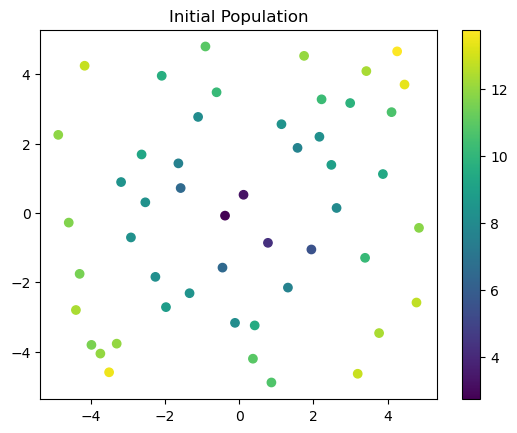

iteration =  0
x min max -2.9231011732311147 1.945168452232875
y min max -2.3178159201815203 1.4288003990314637
(1, 2)
sigma [[2.43413481 2.58770836]]
xbest [-0.38487291 -0.07944564]
lower bound trust shape:   (1, 2)
[[-2.81900773 -2.667154  ]]


/var/folders/8p/wlgb17ln00dg_lln7zq_3gpw0000gn/T/ipykernel_53315/4061782729.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean_module.constant.data = torch.tensor(torch.max(train_y))


trust region best Solution [-0.05297407 -0.07393429]
2.733189642959911 xbestsolution
predicted result =  [2.55781418] actual result =  0.46567448239485687
rho_k =  [12.92948931]
old sigma = [[2.43413481 2.58770836]]
new sigma =  [[3.65120222 3.88156254]]
iteration =  1
lower bound trust shape:   (1, 2)
[[-3.70417629 -3.95549683]]
trust region best Solution [ 0.1687481  -0.16074625]
0.46567448239485687 xbestsolution
predicted result =  [-0.09855971] actual result =  1.7010178412990524
rho_k =  [-2.18941597]
old sigma = [[3.65120222 3.88156254]]
new sigma =  [[0.91280055 0.97039063]]
iteration =  2
lower bound trust shape:   (1, 2)
[[-0.96577462 -1.04432492]]
trust region best Solution [-0.04385672 -0.06419511]
0.46567448239485687 xbestsolution
predicted result =  [0.46111838] actual result =  0.3744020752370827
rho_k =  [20.03299287]
old sigma = [[0.91280055 0.97039063]]
new sigma =  [[1.36920083 1.45558595]]
iteration =  3
lower bound trust shape:   (1, 2)
[[-1.41305756 -1.51978106]]
t

KeyboardInterrupt: 

In [90]:
bounds = [(-5,5), (-5,5)] #bounds for each dimension (x and y)


STRLS = STRLS(bounds, 50, 15)

STRLS.initialTrustRegion(bounds)



In [91]:
import glob
import imageio
import os

image_files = sorted(glob.glob("TRSPlots/*.png"), key=os.path.getmtime)
print(image_files)

images = [Image.open(img) for img in image_files]

# Step 3: Save images as a GIF
if images:
    # 'duration' is the time each frame stays on screen (milliseconds)
    images[0].save(
        "STRLSResult.gif",
        save_all=True,
        append_images=images[1:],  # Include the rest of the images
        duration=1000,               # Duration of each frame in milliseconds
        loop=0                       # 0 means loop indefinitely
    )

['TRSPlots/0.png', 'TRSPlots/1.png', 'TRSPlots/2.png', 'TRSPlots/3.png', 'TRSPlots/4.png', 'TRSPlots/5.png', 'TRSPlots/6.png', 'TRSPlots/7.png', 'TRSPlots/8.png', 'TRSPlots/9.png', 'TRSPlots/10.png', 'TRSPlots/11.png', 'TRSPlots/12.png', 'TRSPlots/13.png', 'TRSPlots/14.png', 'TRSPlots/15.png', 'TRSPlots/16.png', 'TRSPlots/17.png', 'TRSPlots/18.png', 'TRSPlots/19.png', 'TRSPlots/20.png', 'TRSPlots/21.png']
